In [3]:
"""
 Peak alignment between mass spectrum in the whole dataset 
"""
import os
import pandas as pd
import pickle
import biotype.similarity as sim

In [4]:
DATA_DIR_PATH = "datasets/export"
PEAK_DIR_PATH = "extracted_peaks"
files =  os.listdir(DATA_DIR_PATH)
files = [fn  for fn in files if fn.endswith(".txt")]
files = sorted(files)
files[:5]

['L100_0_G7_1.txt',
 'L100_0_G8_1.txt',
 'L101_0_A1_1.txt',
 'L101_0_A2_1.txt',
 'L102_0_A3_1.txt']

In [5]:
n = len(files)
all_peaks = [] # list of tuples (m/z, intensity, dataset_id) ordered by m/z value
for i in range(n):
    df = None
    df = pd.read_table(f"{DATA_DIR_PATH}/{files[i]}",sep=" ", header=None,names=['m/z', 'intensity']) 
    x, y = df['m/z'].to_numpy(), df['intensity'].to_numpy()

    pickle_file = files[i][:-4] # trim '.txt'
    with open(f'{PEAK_DIR_PATH}/{pickle_file}_peaks.pkl', 'rb') as peak_file:
        peaks = pickle.load(peak_file)
        # peaks_extracted +=  [(x[peaks], y[peaks])] 
        for p in peaks:
            all_peaks += [(x[p],y[p], i)]

all_peaks = sorted(all_peaks, key=lambda x: x[0])
all_mz = [mz for mz,pk,ms in all_peaks]
all_mz[:5]

[1000.748, 1000.748, 1000.871, 1000.871, 1000.948]

In [6]:
print(f"min={all_mz[0]}, max={all_mz[-1]}, N={len(all_mz)}")
mz_min, mz_max = all_mz[0], all_mz[-1]

min=1000.748, max=20073.668, N=20923


In [7]:
import pandas as pd
df = pd.DataFrame(all_peaks, columns=['mz', 'intensity', 'dataset_id'])
df.head()

,mz,intensity,dataset_id
0,1000.748,5652,42
1,1000.748,2899,90
2,1000.871,7600,93
3,1000.871,6380,95
4,1000.948,2654,100


In [8]:
df.tail()

,mz,intensity,dataset_id
20918,20070.254,284,47
20919,20070.681,481,7
20920,20071.480,1,0
20921,20071.961,264,61
20922,20073.668,246,82


<AxesSubplot:>

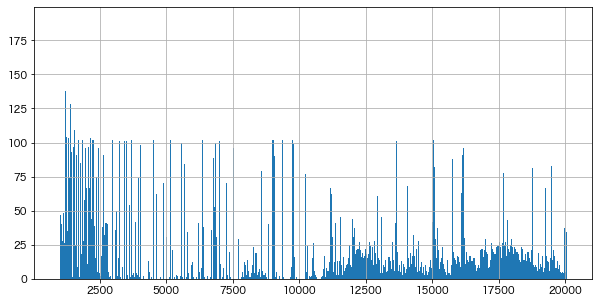

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5     
df['mz'].hist(bins=1000)

In [10]:
import itertools
""" Partition to groups not exceeding delta --> TO BE DELETED
"""
def grouper(iterable, delta=5):
    low = None
    group = []
    for item in iterable:
        if low is None or item - low <= delta:
            group.append(item)
            if low is None:
                low = item
        else:
            yield group
            group = [item]
            low = item
    if group:
        yield group

numbers = [123, 124, 128, 160, 167, 213, 215, 230, 245, 255, 257, 400, 401, 402, 430]
dict(enumerate(grouper(numbers, 15), 1))

{1: [123, 124, 128],
 2: [160, 167],
 3: [213, 215],
 4: [230, 245],
 5: [255, 257],
 6: [400, 401, 402],
 7: [430]}

# Algorithms
- algorithm 1 (segment): reccurisively divide data whenever gap > delta, w.r.t. step=1,2,...
- algorithm 2 (linear_join): reccurisively join leftmost neighbors when span < epsilon
- algorithm 3 (best_join): reccurisively join nearest neighbors when span < epsilon 

# Parameters
- `data`: data to process
- `delta`: reject threshold, data with a gap wider than `delta` will be divided
- `epsilon`: accept threshold, neighbors close enough (`epsilon`) will be joined

In [11]:
def pairwise(iterable):
    """ generate pair of consequent items   
      [s0,s1,s2,s3] -> [(s0, s1), (s1, s2), (s2, s3)]
    """
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a,b)

print (list(pairwise([1,2,3,5,6])))

[(1, 2), (2, 3), (3, 5), (5, 6)]


In [12]:
def segment(sorted_uniques, delta=3):
    """ algorithm 1 (segment): reccurisively divide data whenever gap > delta, w.r.t. step=1,2,3,...
    input: a list of sortd unique m/z values
    ouput: list of indexes. `b[i], b[i+1]` form an open-closed interval, define a cluster  
    """
    # sorted_uniques = sorted(list(set(data)))
    return exec_segment(sorted_uniques,[-1, len(sorted_uniques)-1],  delta, 1)
        
def exec_segment(sorted_uniques, bins, delta, step):
    new_bins = bins[:]
    done = True
    for s, t in pairwise(bins):
        for i in range(s+1, t, step):
            j = i + step
            if j<=t and sorted_uniques [j] - sorted_uniques [i] > delta:
                new_bins += [j-1]
                done = False
                    
    bins = sorted(list(set(new_bins)))
    
    if done:
        return bins
    else:
        return exec_segment(sorted_uniques, bins, delta, step+1)
    

In [13]:
delta = 3
sorted_uniques = sorted(list(set(all_mz)))
bins = segment(sorted_uniques, delta)
print(bins[:10])
print(bins[-10:])

[-1, 12, 37, 47, 67, 70, 90, 91, 120, 138]
[11897, 11901, 11903, 11906, 11907, 11910, 11913, 11917, 11926, 11931]


In [14]:
ob = 0
for i, j in pairwise(bins[-20:]):
    a, b = sorted_uniques[i+1], sorted_uniques[j]
    ok = 'y' if b-a < a-ob else '#BAD: closer to above one' 
    ob = b
    print(f"[{a:.3f}, {b:.3f}]:{j-i:3d} {b-a:.3f} {ok}")

[19983.012, 19985.835]:  7 2.823 y
[19987.539, 19988.628]:  3 1.089 y
[19989.402, 19991.106]:  2 1.704 #BAD: closer to above one
[20001.333, 20002.689]:  2 1.356 y
[20007.988, 20007.988]:  1 0.000 y
[20011.398, 20013.955]:  2 2.557 y
[20022.053, 20022.053]:  1 0.000 y
[20026.317, 20026.743]:  2 0.426 y
[20031.007, 20031.007]:  1 0.000 y
[20034.664, 20034.664]:  1 0.000 y
[20039.109, 20041.061]:  4 1.952 y
[20042.947, 20044.048]:  2 1.101 y
[20045.080, 20048.066]:  3 2.986 #BAD: closer to above one
[20051.052, 20051.052]:  1 0.000 y
[20055.318, 20057.628]:  3 2.310 y
[20058.732, 20061.719]:  3 2.987 #BAD: closer to above one
[20063.425, 20066.413]:  4 2.988 #BAD: closer to above one
[20066.840, 20069.827]:  9 2.987 #BAD: closer to above one
[20070.254, 20073.668]:  5 3.414 #BAD: closer to above one


In [37]:
import statistics as st
def evaluate(bins):
    """evaluate bucketization by (1) average variance, (2) average gap 
    """
    vmin = min([min(a) for a in bins])
    vmax = max([max(a) for a in bins])
    gap = sum([abs(min(b)-max(a)) for a,b in pairwise(bins)])/(vmax-vmin)
    dev = st.mean([st.pstdev(b) for b in bins])
    return gap, dev

In [38]:
def divide(sorted_uniques, delta=3):
    """ algorithm 1' (divide): a new implementation of algorithm a, return cluster of m/z values, instead of indexes
    input: a list of sortd unique m/z values
    ouput: list of m/z value lists, each m/z value list is a cluster 
    """
    bins =[sorted_uniques]
    done, step = False, 1
    while not done:
        new_bins = []
        done = True
        for b in bins: # divide each bin if necessary
            s = 0
            for i in range(0, len(b)-1, step):
                j = i + step
                if j<len(b) and b[j] - b[i] > delta:
                    new_bins += [b[s:j]]
                    s, done = j, False
            
            if s < len(b): # add last part as a new bin
                new_bins += [b[s:]]
                
        bins = new_bins[:] 
        step += 1
        
    return bins 

In [117]:
delta = 2
sorted_uniques = sorted(list(set(all_mz)))
bins = divide(sorted_uniques, delta)

print(bins[:5])
print("*" * 40)
print(bins[-5:])

gap, dev = evaluate(bins)
print("*" * 40)
print(f"gap={gap:.4f}, dev={dev:.4f}")

[[1000.748, 1000.871, 1000.948, 1001.081, 1001.083, 1001.273, 1001.366, 1001.461, 1001.556, 1001.651, 1001.746, 1001.936, 1002.126], [1007.214, 1007.309, 1007.405, 1007.5, 1007.595, 1007.716, 1007.737, 1007.832, 1007.881, 1007.932, 1008.023, 1008.118, 1008.122, 1008.213, 1008.309, 1008.404, 1008.478, 1008.499, 1008.595, 1008.647, 1008.668, 1008.69, 1008.785, 1008.88], [1009.41], [1016.519, 1016.615, 1016.71, 1016.902, 1016.997, 1017.093, 1017.189, 1017.38, 1017.571, 1017.667], [1023.418, 1023.472, 1023.514, 1023.61, 1023.778, 1023.81, 1023.994, 1024.186, 1024.282, 1024.29, 1024.378, 1024.474, 1024.57, 1024.666, 1024.738, 1024.762, 1024.834, 1024.858, 1025.219, 1025.339]]
****************************************
[[20066.84, 20067.266, 20067.693, 20068.12, 20068.547], [20068.973, 20069.4, 20069.579, 20069.827, 20070.254, 20070.681], [20071.48], [20071.961], [20073.668]]
****************************************
gap=0.8297, dev=0.3717


In [118]:
ob = 0
for x in bins[:10]+bins[-10:]:
    a, b = min(x), max(x)
    ok = 'y' if b-a < a-ob else '#BAD: closer to above one' 
    ob = b
    print(f"[{a:.3f}, {b:.3f}]:{len(x):3d} {b-a:.3f} {ok}")

[1000.748, 1002.126]: 13 1.378 y
[1007.214, 1008.880]: 24 1.666 y
[1009.410, 1009.410]:  1 0.000 y
[1016.519, 1017.667]: 10 1.148 y
[1023.418, 1025.339]: 20 1.921 y
[1031.650, 1033.425]:  3 1.775 y
[1044.123, 1046.099]: 18 1.976 y
[1046.196, 1046.584]:  2 0.388 #BAD: closer to above one
[1049.304, 1049.304]:  1 0.000 y
[1053.259, 1055.241]: 25 1.982 y
[20051.052, 20051.052]:  1 0.000 y
[20055.318, 20055.318]:  1 0.000 y
[20057.452, 20058.981]:  4 1.529 y
[20061.719, 20063.425]:  2 1.706 y
[20064.706, 20066.413]:  3 1.707 #BAD: closer to above one
[20066.840, 20068.547]:  5 1.707 #BAD: closer to above one
[20068.973, 20070.681]:  6 1.708 #BAD: closer to above one
[20071.480, 20071.480]:  1 0.000 y
[20071.961, 20071.961]:  1 0.000 y
[20073.668, 20073.668]:  1 0.000 y


In [109]:
def linear_join(sorted_uniques, delta=5, epsilon=1):
    """ algorithm 2 (linear_join): reccurisively join leftmost neighbors when span < epsilon
    input: a list of sortd unique m/z values
    ouput: list of m/z value lists, each m/z value list is a cluster 
    """
    # sorted_uniques = sorted(list(set(data)))
    bins = [[v] for v in sorted_uniques]
    
    for d in reversed(range(15)):
        new_bins = []
        i, e = 0, epsilon/2**d
        while i < len(bins):
            if i == len(bins)-1:
                new_bins += [bins[i]]
                break

            a, b = bins[i], bins[i+1]
            if max(b) - min(a) < e: # |span{a, b}|< e
                new_bins += [a+b]
                i += 2
            else:
                new_bins += [a]
                i += 1
            
        bins = new_bins[:]
        
    return bins


In [114]:
delta, epsilon =5, 2
sorted_uniques = sorted(list(set(all_mz)))
bins = linear_join(sorted_uniques, delta, epsilon)

print(bins[:5])
print("*" * 40)
print(bins[-5:])

gap, dev = evaluate(bins)
print("*" * 40)
print(f"gap={gap:.4f}, dev={dev:.4f}")

[[1000.748, 1000.871, 1000.948, 1001.081, 1001.083, 1001.273, 1001.366, 1001.461, 1001.556, 1001.651, 1001.746, 1001.936, 1002.126], [1007.214, 1007.309, 1007.405, 1007.5, 1007.595, 1007.716, 1007.737, 1007.832, 1007.881, 1007.932, 1008.023, 1008.118, 1008.122, 1008.213, 1008.309, 1008.404, 1008.478, 1008.499, 1008.595, 1008.647, 1008.668, 1008.69, 1008.785, 1008.88], [1009.41], [1016.519, 1016.615, 1016.71, 1016.902, 1016.997, 1017.093, 1017.189, 1017.38, 1017.571, 1017.667], [1023.418, 1023.472, 1023.514, 1023.61, 1023.778, 1023.81, 1023.994, 1024.186, 1024.282, 1024.29, 1024.378, 1024.474, 1024.57, 1024.666, 1024.738, 1024.762, 1024.834, 1024.858]]
****************************************
[[20064.706, 20065.986, 20066.413], [20066.84, 20067.266, 20067.693, 20068.12], [20068.547, 20068.973, 20069.4, 20069.579, 20069.827], [20070.254, 20070.681, 20071.48, 20071.961], [20073.668]]
****************************************
gap=0.8417, dev=0.3519


In [111]:
ob = 0
for x in bins[:10]+bins[-10:]:
    a, b = min(x), max(x)
    ok = 'y' if b-a < a-ob else '#BAD: closer to above one' 
    ob = b
    print(f"[{a:.3f},{b:.3f}] {len(x):3d} d={b-a:.3f}  {ok}")

[1000.748,1002.126]  13 d=1.378  y
[1007.214,1009.410]  25 d=2.196  y
[1016.519,1017.667]  10 d=1.148  y
[1023.418,1025.339]  20 d=1.921  y
[1031.650,1033.425]   3 d=1.775  y
[1044.123,1046.584]  20 d=2.461  y
[1049.304,1049.304]   1 d=0.000  y
[1053.259,1055.729]  29 d=2.470  y
[1061.848,1064.619]  16 d=2.771  y
[1064.717,1066.382]  12 d=1.665  #BAD: closer to above one
[20039.109,20041.061]   4 d=1.952  y
[20042.947,20045.080]   3 d=2.133  #BAD: closer to above one
[20047.387,20048.066]   2 d=0.679  y
[20051.052,20051.052]   1 d=0.000  y
[20055.318,20057.628]   3 d=2.310  y
[20058.732,20061.719]   3 d=2.987  #BAD: closer to above one
[20063.425,20064.706]   2 d=1.281  y
[20065.986,20068.973]   8 d=2.987  #BAD: closer to above one
[20069.400,20071.961]   7 d=2.561  #BAD: closer to above one
[20073.668,20073.668]   1 d=0.000  y


In [104]:
import heapq

def best_join(sorted_uniques, delta, epsilon): 
    """algorithm 3 (best_join): reccurisively join nearest neighbors when span < epsilon
    input: a list of sortd unique m/z values
    ouput: list of m/z value lists, each m/z value list is a cluster 
    """
    bins = [-1, len(sorted_uniques)-1]
    for s, t in pairwise(bins): # divide bucket at gap > delta
        for i in range(s+1, t):
            if sorted_uniques [i+1] - sorted_uniques [i] > delta:
                bins += [i]
                    
    bins = sorted(list(set(bins)))
    my_bins = []
    for s, t in pairwise(bins): 
        new_bins = []
        my_bin = [[v] for v in sorted_uniques[s+1:t+1]]

        done = False
        while not done:
            n = len(my_bin)
            alpha  = lambda x: round(max(my_bin[x+1])-min(my_bin[x]),3)
            pq = [(alpha(x), x) for x in range(n-1) if alpha(x)<epsilon]
            if bool(pq): 
                heapq.heapify(pq)
                d, x= heapq.heappop(pq)
                my_bin = my_bin[:x] + [my_bin[x]+my_bin[x+1]] + my_bin[x+2:]
            else:
                new_bins += my_bin
                done = True
        
        my_bins += new_bins
        
    return sorted(my_bins, key=lambda x: x[0])


In [115]:
delta, epsilon =5, 2
sorted_uniques = sorted(list(set(all_mz)))
bins = best_join(sorted_uniques, delta, epsilon)

print(bins[:5])
print("*" * 40)
print(bins[-5:])

gap, dev = evaluate(bins)
print("*" * 40)
print(f"gap={gap:.4f}, dev={dev:.4f}")

[[1000.748, 1000.871, 1000.948, 1001.081, 1001.083, 1001.273, 1001.366, 1001.461, 1001.556, 1001.651, 1001.746, 1001.936, 1002.126], [1007.214, 1007.309, 1007.405, 1007.5, 1007.595, 1007.716, 1007.737, 1007.832, 1007.881, 1007.932, 1008.023, 1008.118, 1008.122, 1008.213], [1008.309, 1008.404, 1008.478, 1008.499, 1008.595, 1008.647, 1008.668, 1008.69, 1008.785, 1008.88, 1009.41], [1016.519, 1016.615, 1016.71, 1016.902, 1016.997, 1017.093, 1017.189, 1017.38, 1017.571, 1017.667], [1023.418, 1023.472, 1023.514, 1023.61, 1023.778, 1023.81, 1023.994, 1024.186, 1024.282, 1024.29, 1024.378, 1024.474, 1024.57, 1024.666, 1024.738, 1024.762, 1024.834, 1024.858, 1025.219, 1025.339]]
****************************************
[[20065.986, 20066.413, 20066.84, 20067.266], [20067.693, 20068.12, 20068.547, 20068.973], [20069.4, 20069.579, 20069.827, 20070.254, 20070.681], [20071.48, 20071.961], [20073.668]]
****************************************
gap=0.8469, dev=0.3377


In [116]:
ob = 0
for x in bins[:10]+bins[-10:]:
    a, b = min(x), max(x)
    ok = 'y' if b-a < a-ob else '#BAD: closer to above one' 
    ob = b
    print(f"[{a:.3f}, {b:.3f}]:{len(x):3d} {b-a:.3f} {ok}")

[1000.748, 1002.126]: 13 1.378 y
[1007.214, 1008.213]: 14 0.999 y
[1008.309, 1009.410]: 11 1.101 #BAD: closer to above one
[1016.519, 1017.667]: 10 1.148 y
[1023.418, 1025.339]: 20 1.921 y
[1031.650, 1033.425]:  3 1.775 y
[1044.123, 1045.614]: 16 1.491 y
[1045.905, 1046.584]:  4 0.679 #BAD: closer to above one
[1049.304, 1049.304]:  1 0.000 y
[1053.259, 1054.656]: 15 1.397 y
[20051.052, 20051.052]:  1 0.000 y
[20055.318, 20055.318]:  1 0.000 y
[20057.452, 20058.981]:  4 1.529 y
[20061.719, 20061.719]:  1 0.000 y
[20063.425, 20064.706]:  2 1.281 y
[20065.986, 20067.266]:  4 1.280 y
[20067.693, 20068.973]:  4 1.280 #BAD: closer to above one
[20069.400, 20070.681]:  5 1.281 #BAD: closer to above one
[20071.480, 20071.961]:  2 0.481 y
[20073.668, 20073.668]:  1 0.000 y
